<!-- --- -->
title: Spatial Temporal
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
---

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import metpy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
from sklearn import pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian
from jejeqx._src.transforms.dataframe.temporal import TimeDelta
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%env XLA_PYTHON_CLIENT_PREALLOCATE=false

%matplotlib inline
%load_ext autoreload
%autoreload 2

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [1]:
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

In [ ]:
WandbLogger()

## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a problem that a naive network has.

## Data

In [2]:
# !wget wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

In [3]:
from pathlib import Path

In [4]:
Path("/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc").is_file()

True

In [5]:
# @dataclass
# class Subset:
#     _target_: str = "slice"
#     _args_: List = field(default_factory=lambda :["2013-01-01", "2013-01-10"])

In [6]:
from dataclasses import dataclass, field
from typing import List, Dict



# @dataclass
# class SSHDM:
#     _target_: str = "jejeqx._src.datamodules.natl60.SSHSTNATL60"
#     batch_size: int = 10_000
#     shuffle: bool = False
#     split_method: str = "random"
#     train_size: float = 0.80
#     spatial_coords: List = field(default_factory=lambda : ["x", "y", "z"])
#     temporal_coords: List = field(default_factory=lambda: ["time"])
#     variables: List = field(default_factory=lambda : ["ssh"])
#     coarsen: Dict = field(default_factory=lambda : {"lon": 4, "lat": 4})
#     directory: str = "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/"
    
    
@dataclass
class SSHDM:
    _target_: str = "jejeqx._src.datamodules.coords.AlongTrackDM"
    batch_size: int = 10_000
    shuffle: bool = False
    train_size: float = 0.80
    subset_size: float = 0.50
    spatial_coords: List = field(default_factory=lambda : ["lat", "lon"])
    temporal_coords: List = field(default_factory=lambda: ["time"])
    variables: List = field(default_factory=lambda : ["sossheig"])
    coarsen: Dict = field(default_factory=lambda : {"lon": 4, "lat": 4})
    resample: str = "1D"
    # paths: str = "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc"
    paths: str = "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/test/dc_ref/NATL60-CJM165_GULFSTREAM*"

# spatial transform
spatial_transforms = Pipeline([
    ("cartesian3d", Spherical2Cartesian(radius=1.0, units="degrees")),
    ("spatialminmax", MinMaxDF(["x", "y", "z"], -1, 1)),
])

temporal_transforms = Pipeline([
    ("timedelta", TimeDelta("2012-10-01", 1, "s")),
    ("timeminmax", MinMaxDF(["time"], -1, 1)),
])

In [7]:
select = {"time": slice("2013-01-01", "2013-01-30")}

config_dm = OmegaConf.structured(SSHDM())

dm = hydra.utils.instantiate(
    config_dm,
    select=select,
    spatial_transform=spatial_transforms,
    temporal_transform=temporal_transforms,
)

dm.setup()



init = dm.ds_train[:32]
x_init, t_init, y_init = init["spatial"], init["temporal"], init["data"]
x_init.min(), x_init.max(), x_init.shape, t_init.min(), t_init.max(), t_init.shape

/gpfsdswork/projects/rech/cli/uvo53rl/projects/jejeqx/jejeqx/_src/transforms/dataframe/temporal.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["time"] = time
/gpfsdswork/projects/rech/cli/uvo53rl/projects/jejeqx/jejeqx/_src/transforms/dataframe/scaling.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[self.columns] = X_var


(-1.0, 0.9624996702391933, (32, 3), -0.8620689655172411, 1.0, (32, 1))

In [8]:
len(dm.ds_train), len(dm.ds_test)

(270000, 675000)

In [9]:
xrda = dm.load_xrds()

In [9]:
# import geoviews as gv
# import geoviews.feature as gf
# from cartopy import crs

# gv.extension('bokeh', 'matplotlib')

In [10]:
xrda

<xarray.Dataset>
Dimensions:   (time: 15, lat: 150, lon: 150)
Coordinates:
  * lon       (lon) float64 -64.96 -64.89 -64.83 -64.76 ... -55.16 -55.09 -55.03
  * lat       (lat) float64 33.04 33.11 33.17 33.24 ... 42.77 42.84 42.91 42.97
  * time      (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-01-15
Data variables:
    sossheig  (time, lat, lon) float32 0.5274 0.519 0.5105 ... -0.1825 -0.1765
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

In [10]:
# dataset = gv.Dataset(xrda)
# ensemble1 = dataset.to(gv.Image, ['lon', 'lat'], "ssh")
# ensemble2 = dataset.to(gv.Image, ['lon', 'lat'], "ssh_lmsiren")
# gv.output(ensemble1.opts(cmap='viridis', colorbar=True, fig_size=200, backend='matplotlib') * gf.coastline(),
#           backend='matplotlib')

In [11]:
# dataset = gv.Dataset(xrda)
# ensemble = dataset.to(gv.Image, ['lon', 'lat'], "ssh_lmsiren")

# gv.output(ensemble.opts(cmap='viridis', colorbar=True, fig_size=200, backend='matplotlib') * gf.coastline(),
#           backend='matplotlib')

In [12]:
from jejeqx._src.nets.nerfs.ffn import RFFLayer

model_name = "rff"


model = eqx.nn.Sequential(
    [RFFLayer(in_dim=4, num_features=256, out_dim=256, key=jrandom.PRNGKey(42)),
     RFFLayer(in_dim=256, num_features=256, out_dim=256, key=jrandom.PRNGKey(123)),
     RFFLayer(in_dim=256, num_features=256, out_dim=256, key=jrandom.PRNGKey(23)),
     RFFLayer(in_dim=256, num_features=256, out_dim=256, key=jrandom.PRNGKey(81)),
     RFFLayer(in_dim=256, num_features=256, out_dim=1, key=jrandom.PRNGKey(32)),
    ]
)


# check output of models
out = jax.vmap(model)(jnp.hstack([x_init,t_init]))

assert out.shape == y_init.shape

## Optimizer (+ Learning Rate)

In [13]:
import optax

num_epochs = 2_000

@dataclass
class Optimizer:
    _target_: str = "optax.adam"
    learning_rate: float = 1e-4
# @dataclass
# class Scheduler:
#     _target_: str = "optax.warmup_exponential_decay_schedule"
#     init_value: float = 0.0
#     peak_value: float = 1e-2
#     warmup_steps: int = 100
#     end_value: float = 1e-5
#     decay_rate: float = 0.1

# FINETUNE!
@dataclass
class Scheduler:
    _target_: str = "optax.warmup_cosine_decay_schedule"
    init_value: float = 0.0
    peak_value: float = 1e-2
    warmup_steps: int = 500
    end_value: float = 1e-6
    
scheduler_config = OmegaConf.structured(Scheduler())

In [14]:
optim_config = OmegaConf.structured(Optimizer())

optimizer = hydra.utils.instantiate(optim_config)

# num_steps_per_epoch = len(dm.ds_train)

# scheduler = hydra.utils.instantiate(
#     scheduler_config, 
#     decay_steps=int(num_epochs * num_steps_per_epoch)
# )

# optimizer = optax.chain(optimizer, optax.scale_by_schedule(scheduler))

## Trainer Module

In [15]:
import glob
import os
from pathlib import Path

from jejeqx._src.trainers.base import TrainerModule
from jejeqx._src.trainers.callbacks import wandb_model_artifact
from jejeqx._src.losses import psnr


class RegressorTrainer(TrainerModule):
    def __init__(self,
                 model,
                 optimizer,
                 **kwargs):
        super().__init__(
            model=model, 
            optimizer=optimizer, 
            pl_logger=None,
            **kwargs
        )
        
    @property
    def model(self):
        return self.state.params

    @property
    def model_batch(self):
        return jax.vmap(self.state.params, in_axes=(0,0))

    def create_functions(self):

        @eqx.filter_value_and_grad
        def mse_loss(model, batch):
            x, t, y = batch["spatial"], batch["temporal"], batch["data"]
            pred = jax.vmap(model)(jnp.hstack([x, t]))
            # x, t, y = batch["spatial"], batch["temporal"], batch["data"]
            # pred = jax.vmap(model, in_axes=(0,0))(x, t)
            loss = jnp.mean((y - pred)**2)
            return loss
        
        def train_step(state, batch):
            
            loss, grads = mse_loss(state.params, batch)
            state = state.update_state(state, grads)
            psnr_loss = psnr(loss) 
            metrics = {"loss": loss, "psnr": psnr_loss}
            return state, loss, metrics
        
        def eval_step(model, batch):
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss) 
            return {"loss": loss, "psnr": psnr_loss}

        def test_step(model, batch):
            x, t, y = batch["spatial"], batch["temporal"], batch["data"]
            out = jax.vmap(model)(jnp.hstack([x, t]))
            loss, _ = mse_loss(model, batch)
            psnr_loss = psnr(loss)
            return out, {"loss": loss, "psnr": psnr_loss}
        
        def predict_step(model, batch):
            x, t = batch["spatial"], batch["temporal"]
            out = jax.vmap(model)(jnp.hstack([x, t]))
            return out

        return train_step, eval_step, test_step, predict_step
    
    
    def on_training_end(self,):
        
        if self.pl_logger:
            save_dir = Path(self.log_dir).joinpath(self.save_name)
            self.save_model(save_dir)
            wandb_model_artifact(self)
            self.pl_logger.finalize("success")
        
        


In [16]:
seed = 123
debug = False
enable_progress_bar = False
log_dir = "./"

trainer = RegressorTrainer(
    model, 
    optimizer, 
    seed=seed, 
    debug=debug, 
    enable_progress_bar=enable_progress_bar,
    log_dir=log_dir
)

train_more = True
save_new = True

In [17]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 5.07 s, sys: 121 ms, total: 5.19 s
Wall time: 4.51 s


{'loss': 0.26178741220810237, 'psnr': 7.734110572243313}

In [18]:
# trainer.load_model("./checkpoints/checkpoint_model_stlmsiren_ssh_more.ckpt")
trainer.load_model("./checkpoints/checkpoint_natl60_model_rff.ckpt")

In [19]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 4.55 s, sys: 60.1 ms, total: 4.61 s
Wall time: 3.9 s


{'loss': 0.03115538443458673, 'psnr': 38.69834518664164}

In [20]:
%%time

metrics = trainer.train_model(dm, num_epochs=num_epochs)

Epochs: 2000 | Loss: 4.230e-06: 100%|██████████| 2000/2000 [44:54<00:00,  1.35s/it]

CPU times: user 45min 29s, sys: 22.3 s, total: 45min 51s
Wall time: 44min 54s


In [21]:
%%time


out, metrics = trainer.test_model(dm.test_dataloader())
metrics

CPU times: user 2.6 s, sys: 26.2 ms, total: 2.63 s
Wall time: 2.57 s


{'loss': 5.578741905472238e-06, 'psnr': 114.18227677716516}

In [22]:
if save_new:
    # trainer.save_model("./checkpoints/check point_model_stlmsiren_ssh_more.ckpt")
    trainer.save_model("./checkpoints/checkpoint_natl60_model_rff.ckpt")
# # trainer.save_state("checkpoint_state.ckpt")

In [23]:
xrda["ssh_rff"] = dm.data_to_df(out).to_xarray().sossheig

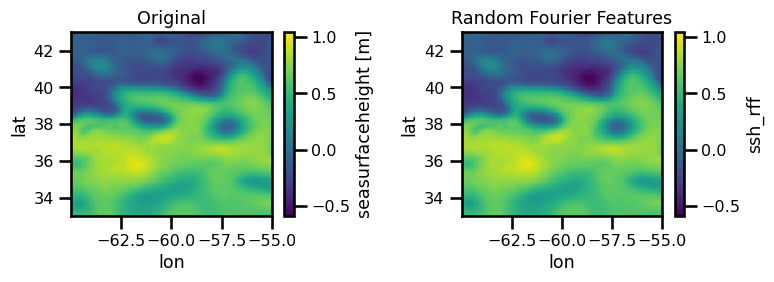

In [24]:
itime = 5

fig, ax = plt.subplots(ncols=2, figsize=(8,3))

vmin = np.min([xrda.sossheig.min(), xrda.ssh_rff.min()])
vmax = np.min([xrda.sossheig.max(), xrda.ssh_rff.max()])

xrda.sossheig.isel(time=itime).plot.pcolormesh(
    ax=ax[0], cmap="viridis", vmin=vmin, vmax=vmax, robust=True
)
ax[0].set(title="Original")

xrda.ssh_rff.isel(time=itime).plot.pcolormesh(
    ax=ax[1], cmap="viridis", vmin=vmin, vmax=vmax, robust=True
)
ax[1].set(title="Random Fourier Features")

plt.tight_layout()
plt.show()

## Analysis

In [44]:
import common_utils as cutils

In [47]:
ds_rff = cutils.calculate_physical_quantities(xrda.ssh_rff)
ds_natl60 = cutils.calculate_physical_quantities(xrda.sossheig)

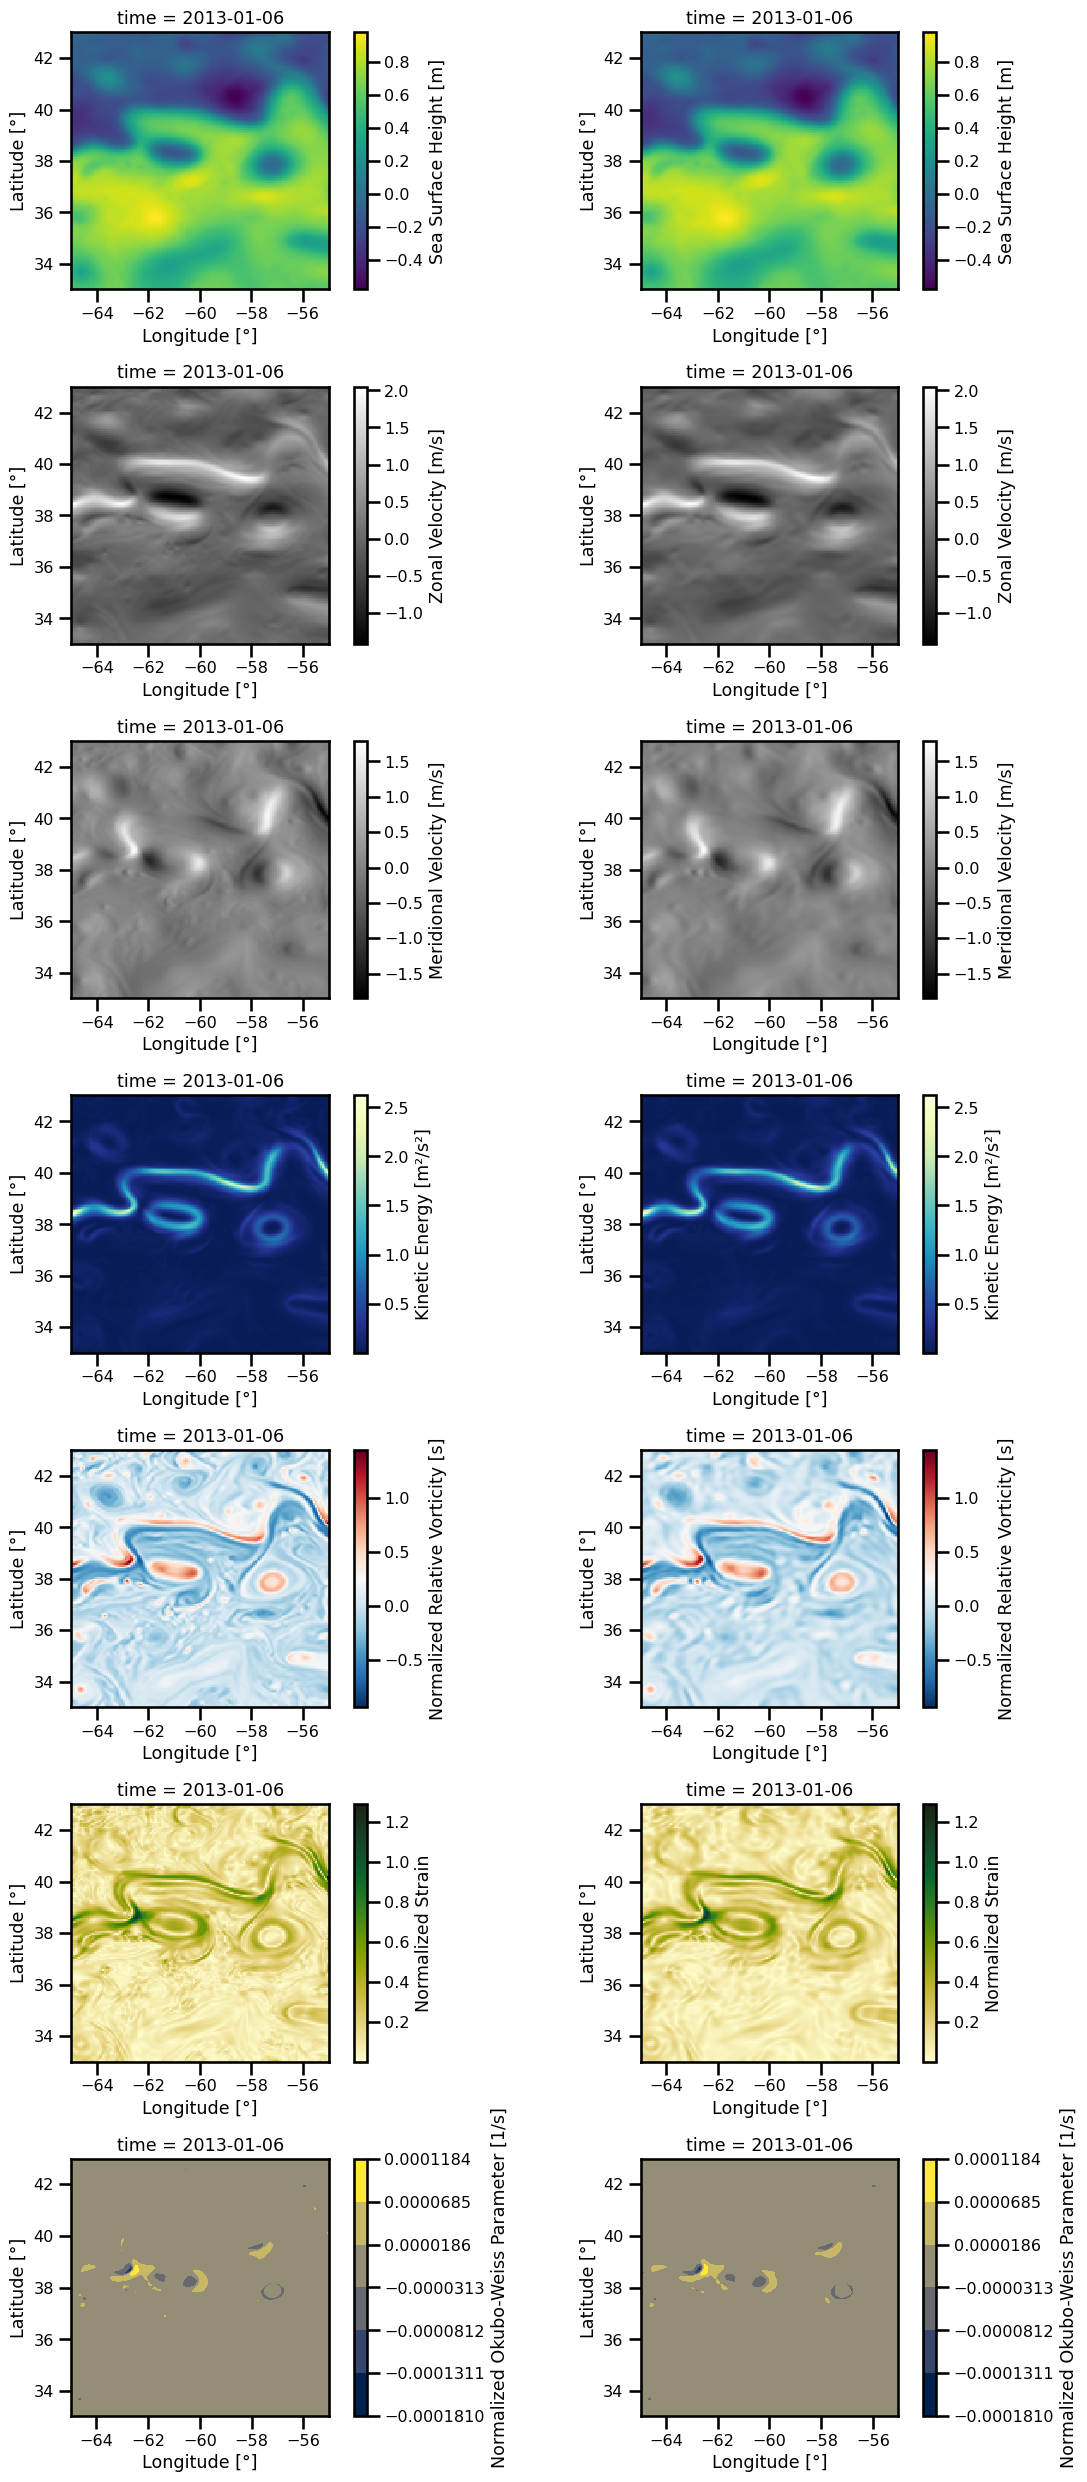

In [58]:
fig, ax = cutils.plot_analysis_vars([
    ds_natl60.isel(time=5),
    ds_rff.isel(time=5),],
    figsize=(12,25),
)
plt.show()

In [252]:
ds_psd_natl60 = cutils.calculate_isotropic_psd(ds_natl60)
ds_psd_rff = cutils.calculate_isotropic_psd(ds_rff)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

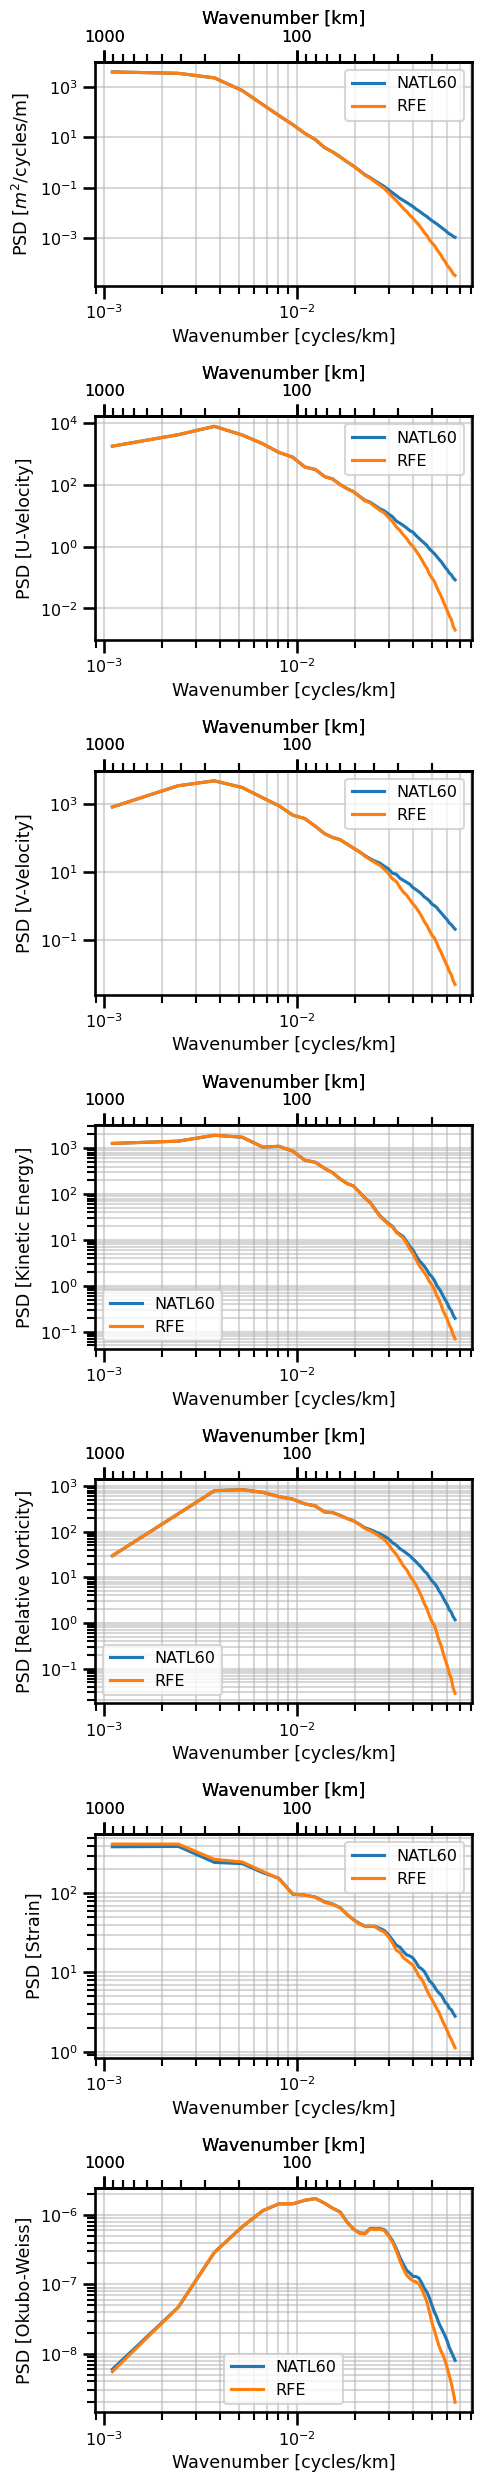

In [253]:
fig, ax = cutils.plot_analysis_psd_iso(
    [ds_psd_natl60, ds_psd_rff,],
    ["NATL60","RFE", ]
)
plt.show()

In [254]:
ds_scores = calculate_isotropic_psd_score(ds_rff, ds_natl60)

  0%|          | 0/4 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


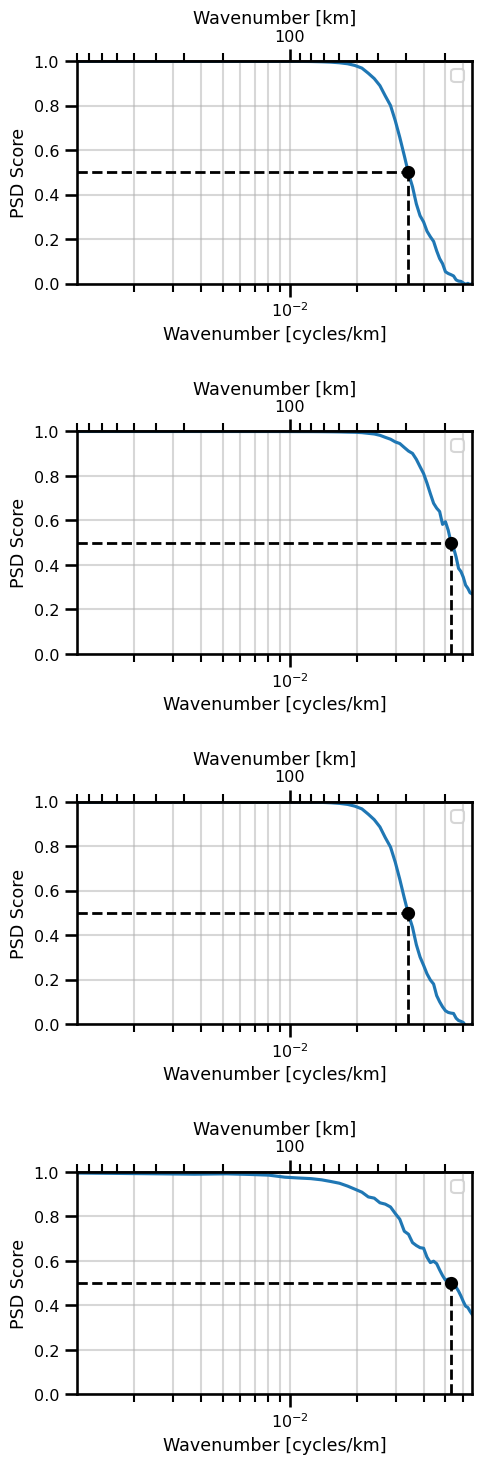

In [255]:
cutils.plot_analysis_psd_iso_score([ds_scores], ["RFE"], ["k"])
plt.show()

In [276]:
ds_psd_natl60 = cutils.calculate_spacetime_psd(ds_natl60)
ds_psd_rff = cutils.calculate_spacetime_psd(ds_rff)


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

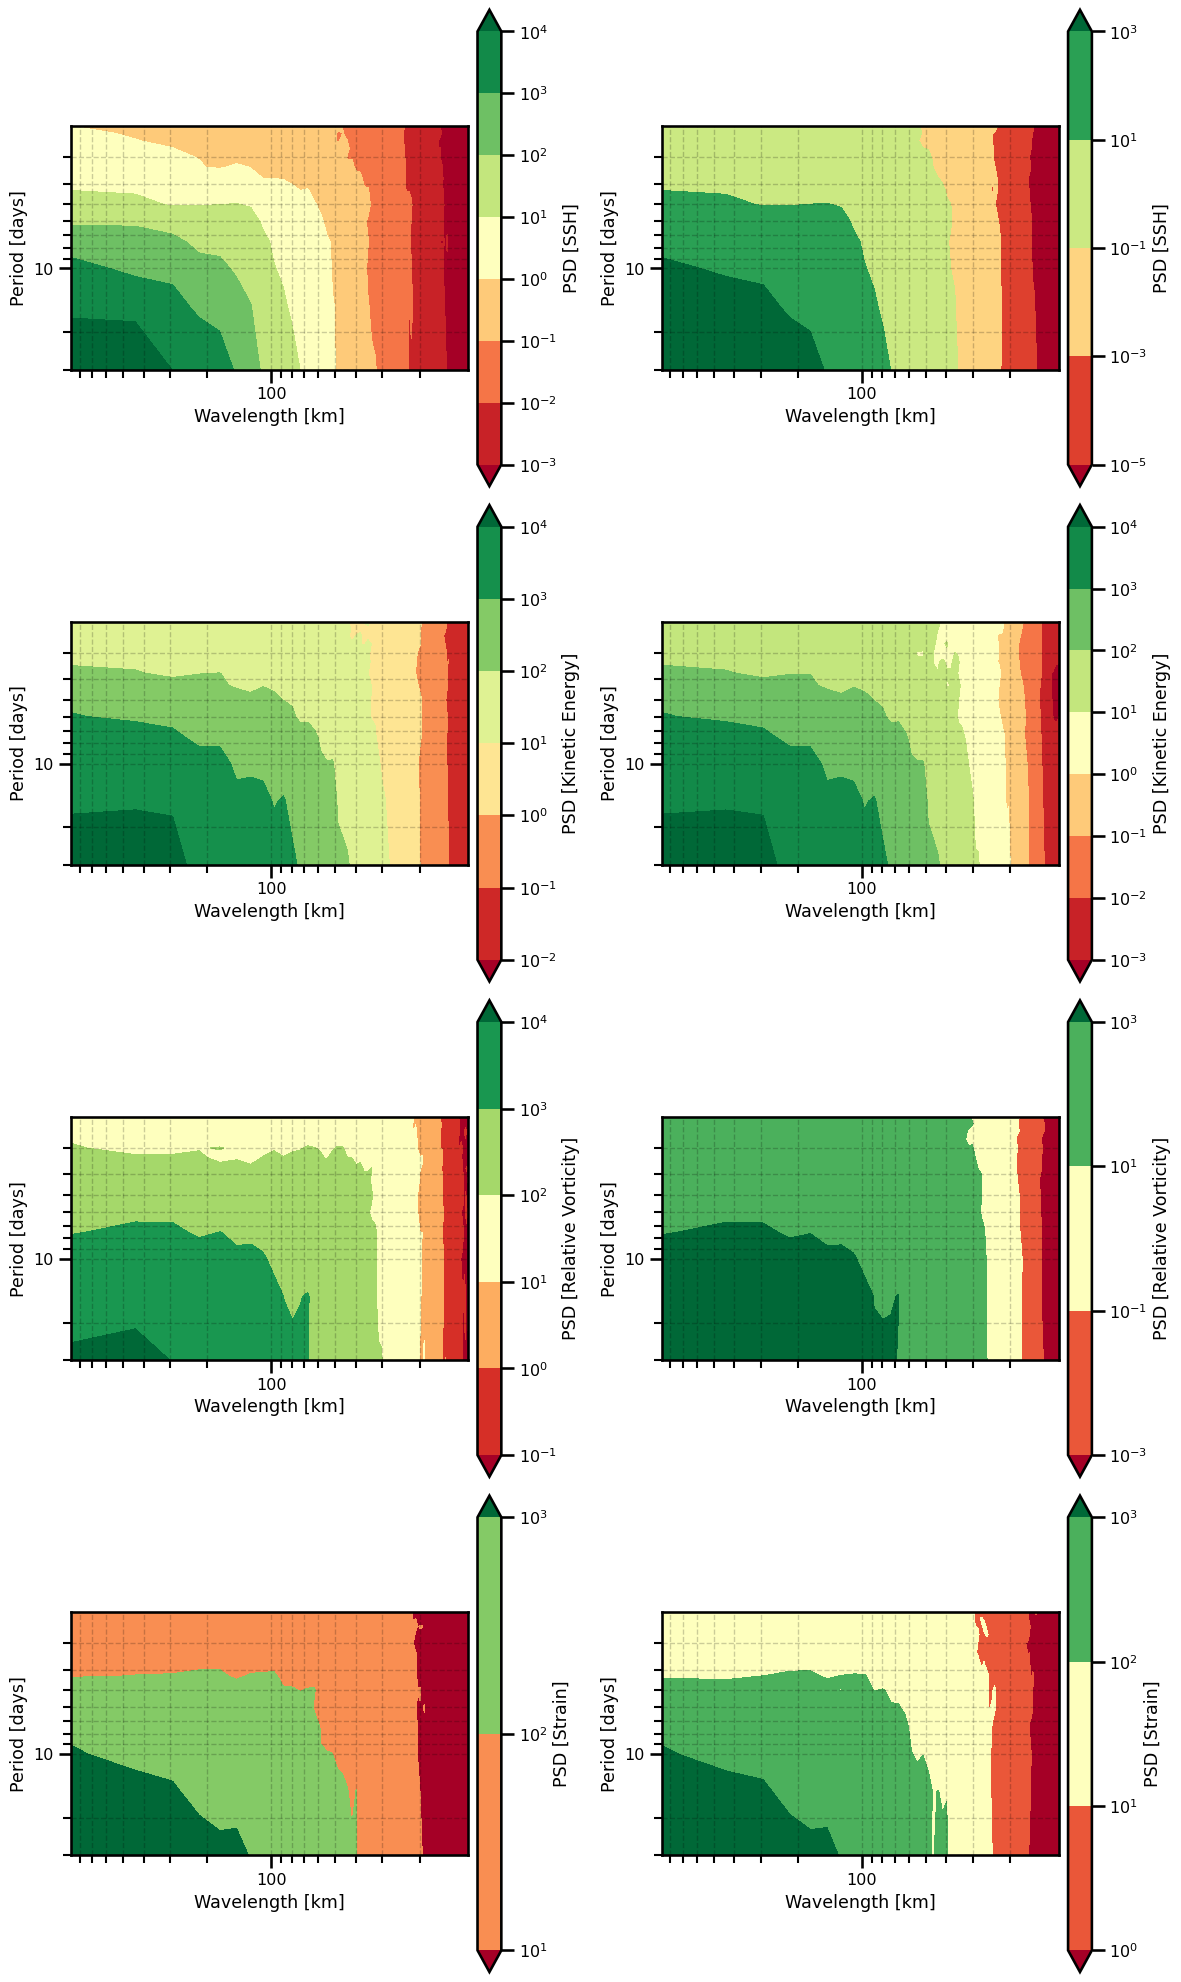

In [277]:
fig, ax = cutils.plot_analysis_psd_spacetime(
    [ds_psd_natl60, ds_psd_rff,],
    ["NATL60","RFE", ]
)
plt.show()

In [261]:
ds_psd_rff = cutils.calculate_spacetime_psd_score(ds_rff, ds_natl60)

  0%|          | 0/4 [00:00<?, ?it/s]

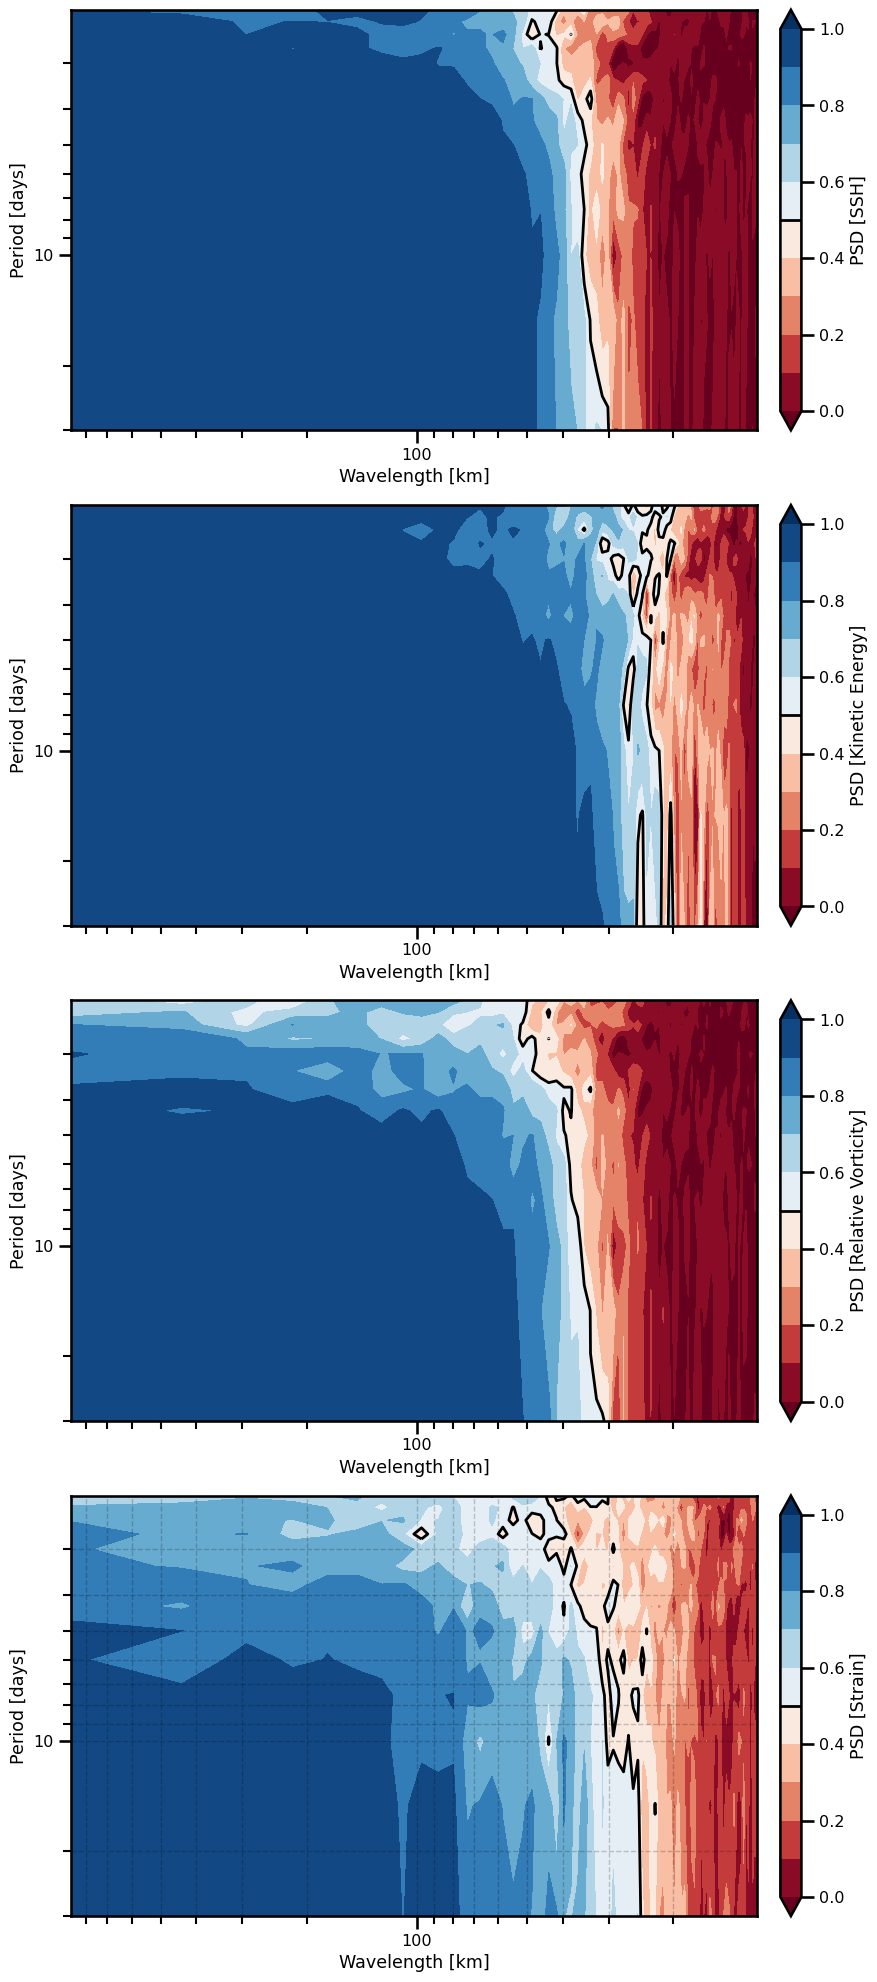

In [263]:
_ = cutils.plot_analysis_psd_spacetime_score(
    [ds_psd_rff], ["rff"]
)